In [33]:
# Built-in python libraries
import os
import re

# General libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Preprocessing and training libraries
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# Custom Setup
%matplotlib inline
matplotlib.style.use('seaborn-paper')
sns.set(style='darkgrid')
sns.set_theme(context='notebook', style='darkgrid', palette='husl')
pd.set_option('display.max_columns', None) # display all columns in pandas

/var/folders/49/199vrwcn1zqb7rx4rgy0xhbr0000gn/T/ipykernel_40413/10443111.py:28: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  matplotlib.style.use('seaborn-paper')


We aim to develop a predictive model utilizing the UCI Diabetes 130-US hospitals for years 1999-2008 dataset. This model will forecast the likelihood of hospital readmission for diabetic patients based on various input features such as the number of procedures and medications, the count of diagnoses, and admission type, among others.

The target classes for prediction are categorized as follows:

- "<30" denoting readmission within less than 30 days.
- ">30" indicating readmission after more than 30 days.
- "No" representing no recorded instance of readmission.

Our process will encompass all stages, from data ingestion and preprocessing to model selection and performance evaluation.

# Data exploration and Data cleaning

In [34]:
dataset_path = '/Users/kaziamithasan/Desktop/Courses/Winter 24/CISC 839/A2/C2T1Data/'

df = pd.read_csv(os.path.join(dataset_path, 'C2T1_Train.csv'), na_values='?') # make ?? as nan
df.rename(columns={"encounter_id2": "encounter_id", "patient_nbr2": "patient_nbr"}, inplace=True)

print("The shape of the dataset is {}.\n\n".format(df.shape))

df.head()

The shape of the dataset is (90766, 50).




/var/folders/49/199vrwcn1zqb7rx4rgy0xhbr0000gn/T/ipykernel_40413/4203440486.py:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(dataset_path, 'C2T1_Train.csv'), na_values='?') # make ?? as nan


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,5283,48330653,Caucasian,Female,[80-90),NaN,2,1,4,13,NaN,NaN,68,2,28,0,0,0,398,427,38,8,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
1,8499,63555809,Caucasian,Female,[90-100),NaN,3,3,4,12,NaN,InternalMedicine,33,3,18,0,0,0,434,198,486,8,None,None,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
2,9441,42519137,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
3,20997,89868902,AfricanAmerican,Female,[40-50),NaN,1,1,7,9,NaN,NaN,47,2,17,0,0,0,250.7,403,996,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,>30
4,28515,82637321,Caucasian,Male,[50-60),NaN,2,1,2,3,NaN,NaN,31,6,16,0,0,0,414,411,250,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,>30


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90766 entries, 0 to 90765
Data columns (total 50 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   encounter_id              90766 non-null  int64 
 1   patient_nbr               90766 non-null  int64 
 2   race                      88559 non-null  object
 3   gender                    90766 non-null  object
 4   age                       90766 non-null  object
 5   weight                    2926 non-null   object
 6   admission_type_id         90766 non-null  int64 
 7   discharge_disposition_id  90766 non-null  int64 
 8   admission_source_id       90766 non-null  int64 
 9   time_in_hospital          90766 non-null  int64 
 10  payer_code                52036 non-null  object
 11  medical_specialty         47092 non-null  object
 12  num_lab_procedures        90766 non-null  int64 
 13  num_procedures            90766 non-null  int64 
 14  num_medications       

We'll begin by importing the dataset, giving it a quick overview, and subsequently dividing it into training and testing sets.

In [36]:
X = df.drop(['readmitted'],axis=1)
y = df['readmitted'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.1,
                                                    random_state=42)

We will allocate 90% of the dataset for training and cross-validation purposes, reserving the remaining 10% for testing. This choice was informed by both the modeling requirements and the nature of the problem, as providing ample data to the model typically enhances accuracy.

To address the imbalance in the data, we will employ stratified splitting based on the target labels.

In [37]:
train_data = pd.concat([X_train,y_train], axis=1)
train_data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
88648,415608521,40402490,Caucasian,Female,[90-100),NaN,1,3,7,3,MC,NaN,56,0,18,0,0,0,574,276,414,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
17290,63835599,327983,Caucasian,Female,[50-60),NaN,1,18,7,5,NaN,NaN,49,3,14,0,0,1,410,493,414,8,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
60982,209626797,5056997,AfricanAmerican,Male,[60-70),NaN,1,1,7,1,MD,NaN,36,3,7,0,0,0,780,924,E816,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,NO
17755,64941969,104615933,Caucasian,Male,[50-60),NaN,1,3,7,13,NaN,NaN,53,1,26,1,0,2,250.02,403,413,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,<30
41082,127324875,103305398,Asian,Male,[50-60),NaN,2,1,7,6,SP,Emergency/Trauma,39,4,7,0,0,1,996,38,403,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,>30



Analyzing and gaining insights from the training data.

In [38]:
cat_cols = [
    'race', 'gender', 'age', 'weight', 'admission_type_id',
    'discharge_disposition_id', 'admission_source_id', 'payer_code',
    'medical_specialty', 'max_glu_serum',
    'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
    'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
    'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
    'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin',
    'glipizide-metformin', 'glimepiride-pioglitazone',
    'metformin-rosiglitazone', 'metformin-pioglitazone', 'change',
    'diabetesMed'
]
num_cols = [
    'time_in_hospital', 'num_lab_procedures', 'num_procedures',
    'num_medications', 'number_outpatient', 'number_emergency',
    'number_inpatient', 'number_diagnoses'
]

ID_cols = ["encounter_id", "patient_nbr"]
diag_cols = ['diag_1', 'diag_2', 'diag_3']


Segmenting the columns into categorical, numerical, ID, and diag columns.

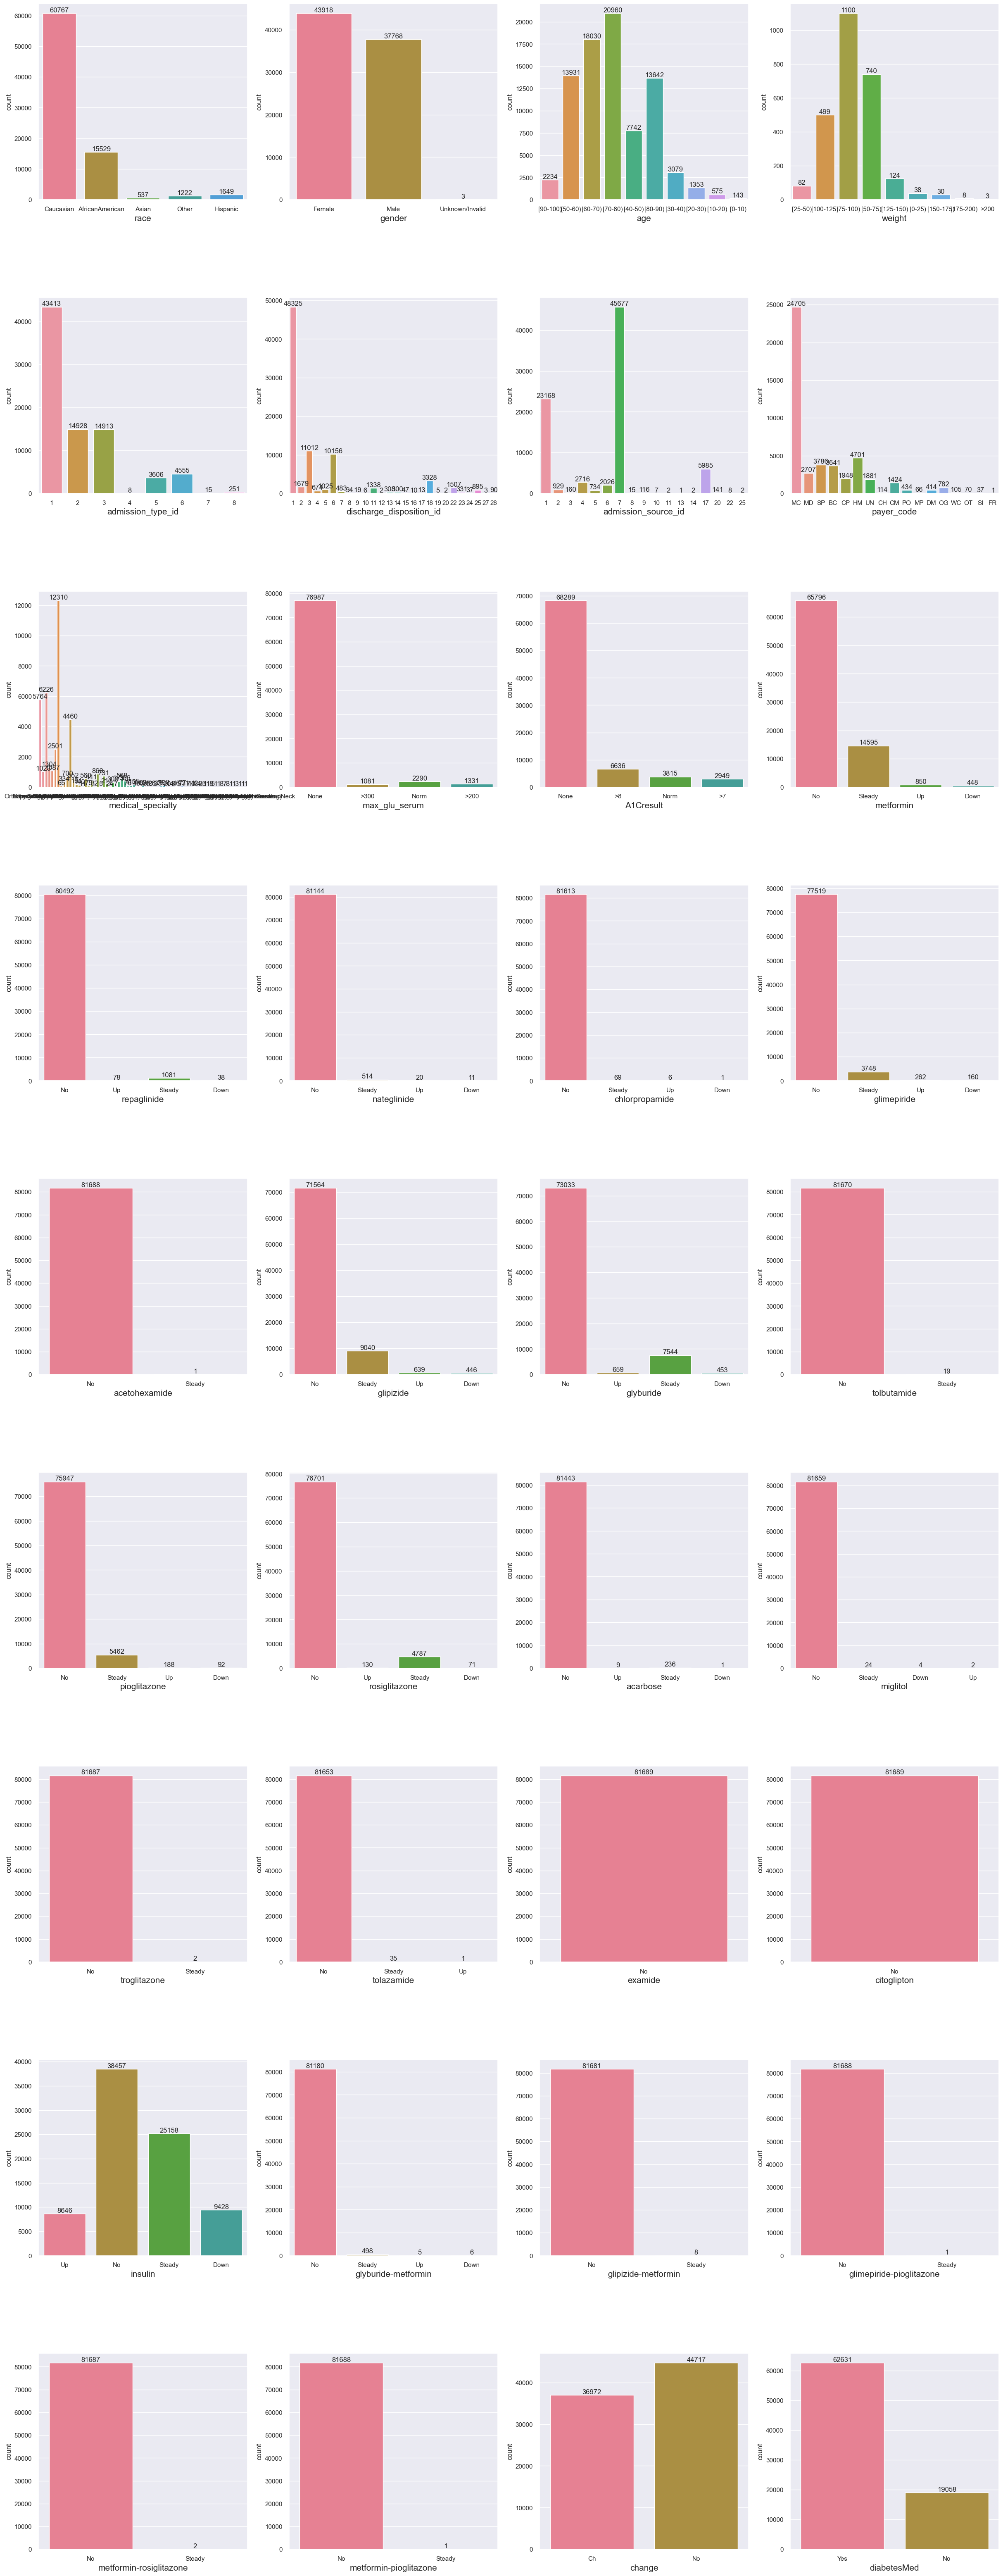

In [39]:
fig, axs = plt.subplots(nrows=9, ncols=4, figsize=(30, 80))
plt.subplots_adjust(hspace=0.5)

for column, ax in zip(cat_cols, axs.ravel()):
    sns.countplot(x=train_data[column], ax=ax)
    ax.set_xlabel(column, fontsize=15)
    for container in ax.containers:
        ax.bar_label(container, fontsize=12)

plt.show()

We will examine the distribution of each category within every categorical column.

In [40]:
cols_to_drop = ['weight','medical_specialty','chlorpropamide','acetohexamide','weight','tolbutamide',
    'acarbose','miglitol','troglitazone','tolazamide','examide','citoglipton',
    'glyburide-metformin','glipizide-metformin','glimepiride-pioglitazone',
    'metformin-rosiglitazone','metformin-pioglitazone']

We will eliminate columns with negligible or minimal variance, as they contribute little to the model's predictive power.

We'll also discard the "weight" and "medical_specialty" columns due to the significant portion of missing values.

In [41]:
train_data[num_cols].describe().T


,count,mean,std,min,25%,50%,75%,max
time_in_hospital,81689.0,4.403163,2.993828,1.0,2.0,4.0,6.0,14.0
num_lab_procedures,81689.0,42.830871,19.776233,1.0,31.0,44.0,57.0,132.0
num_procedures,81689.0,1.337842,1.700669,0.0,0.0,1.0,2.0,6.0
num_medications,81689.0,15.896302,8.108555,1.0,10.0,15.0,20.0,81.0
number_outpatient,81689.0,0.344820,1.173471,0.0,0.0,0.0,0.0,38.0
number_emergency,81689.0,0.190430,0.942602,0.0,0.0,0.0,0.0,76.0
number_inpatient,81689.0,0.624907,1.257179,0.0,0.0,0.0,1.0,21.0
number_diagnoses,81689.0,7.381006,1.949155,1.0,6.0,8.0,9.0,16.0


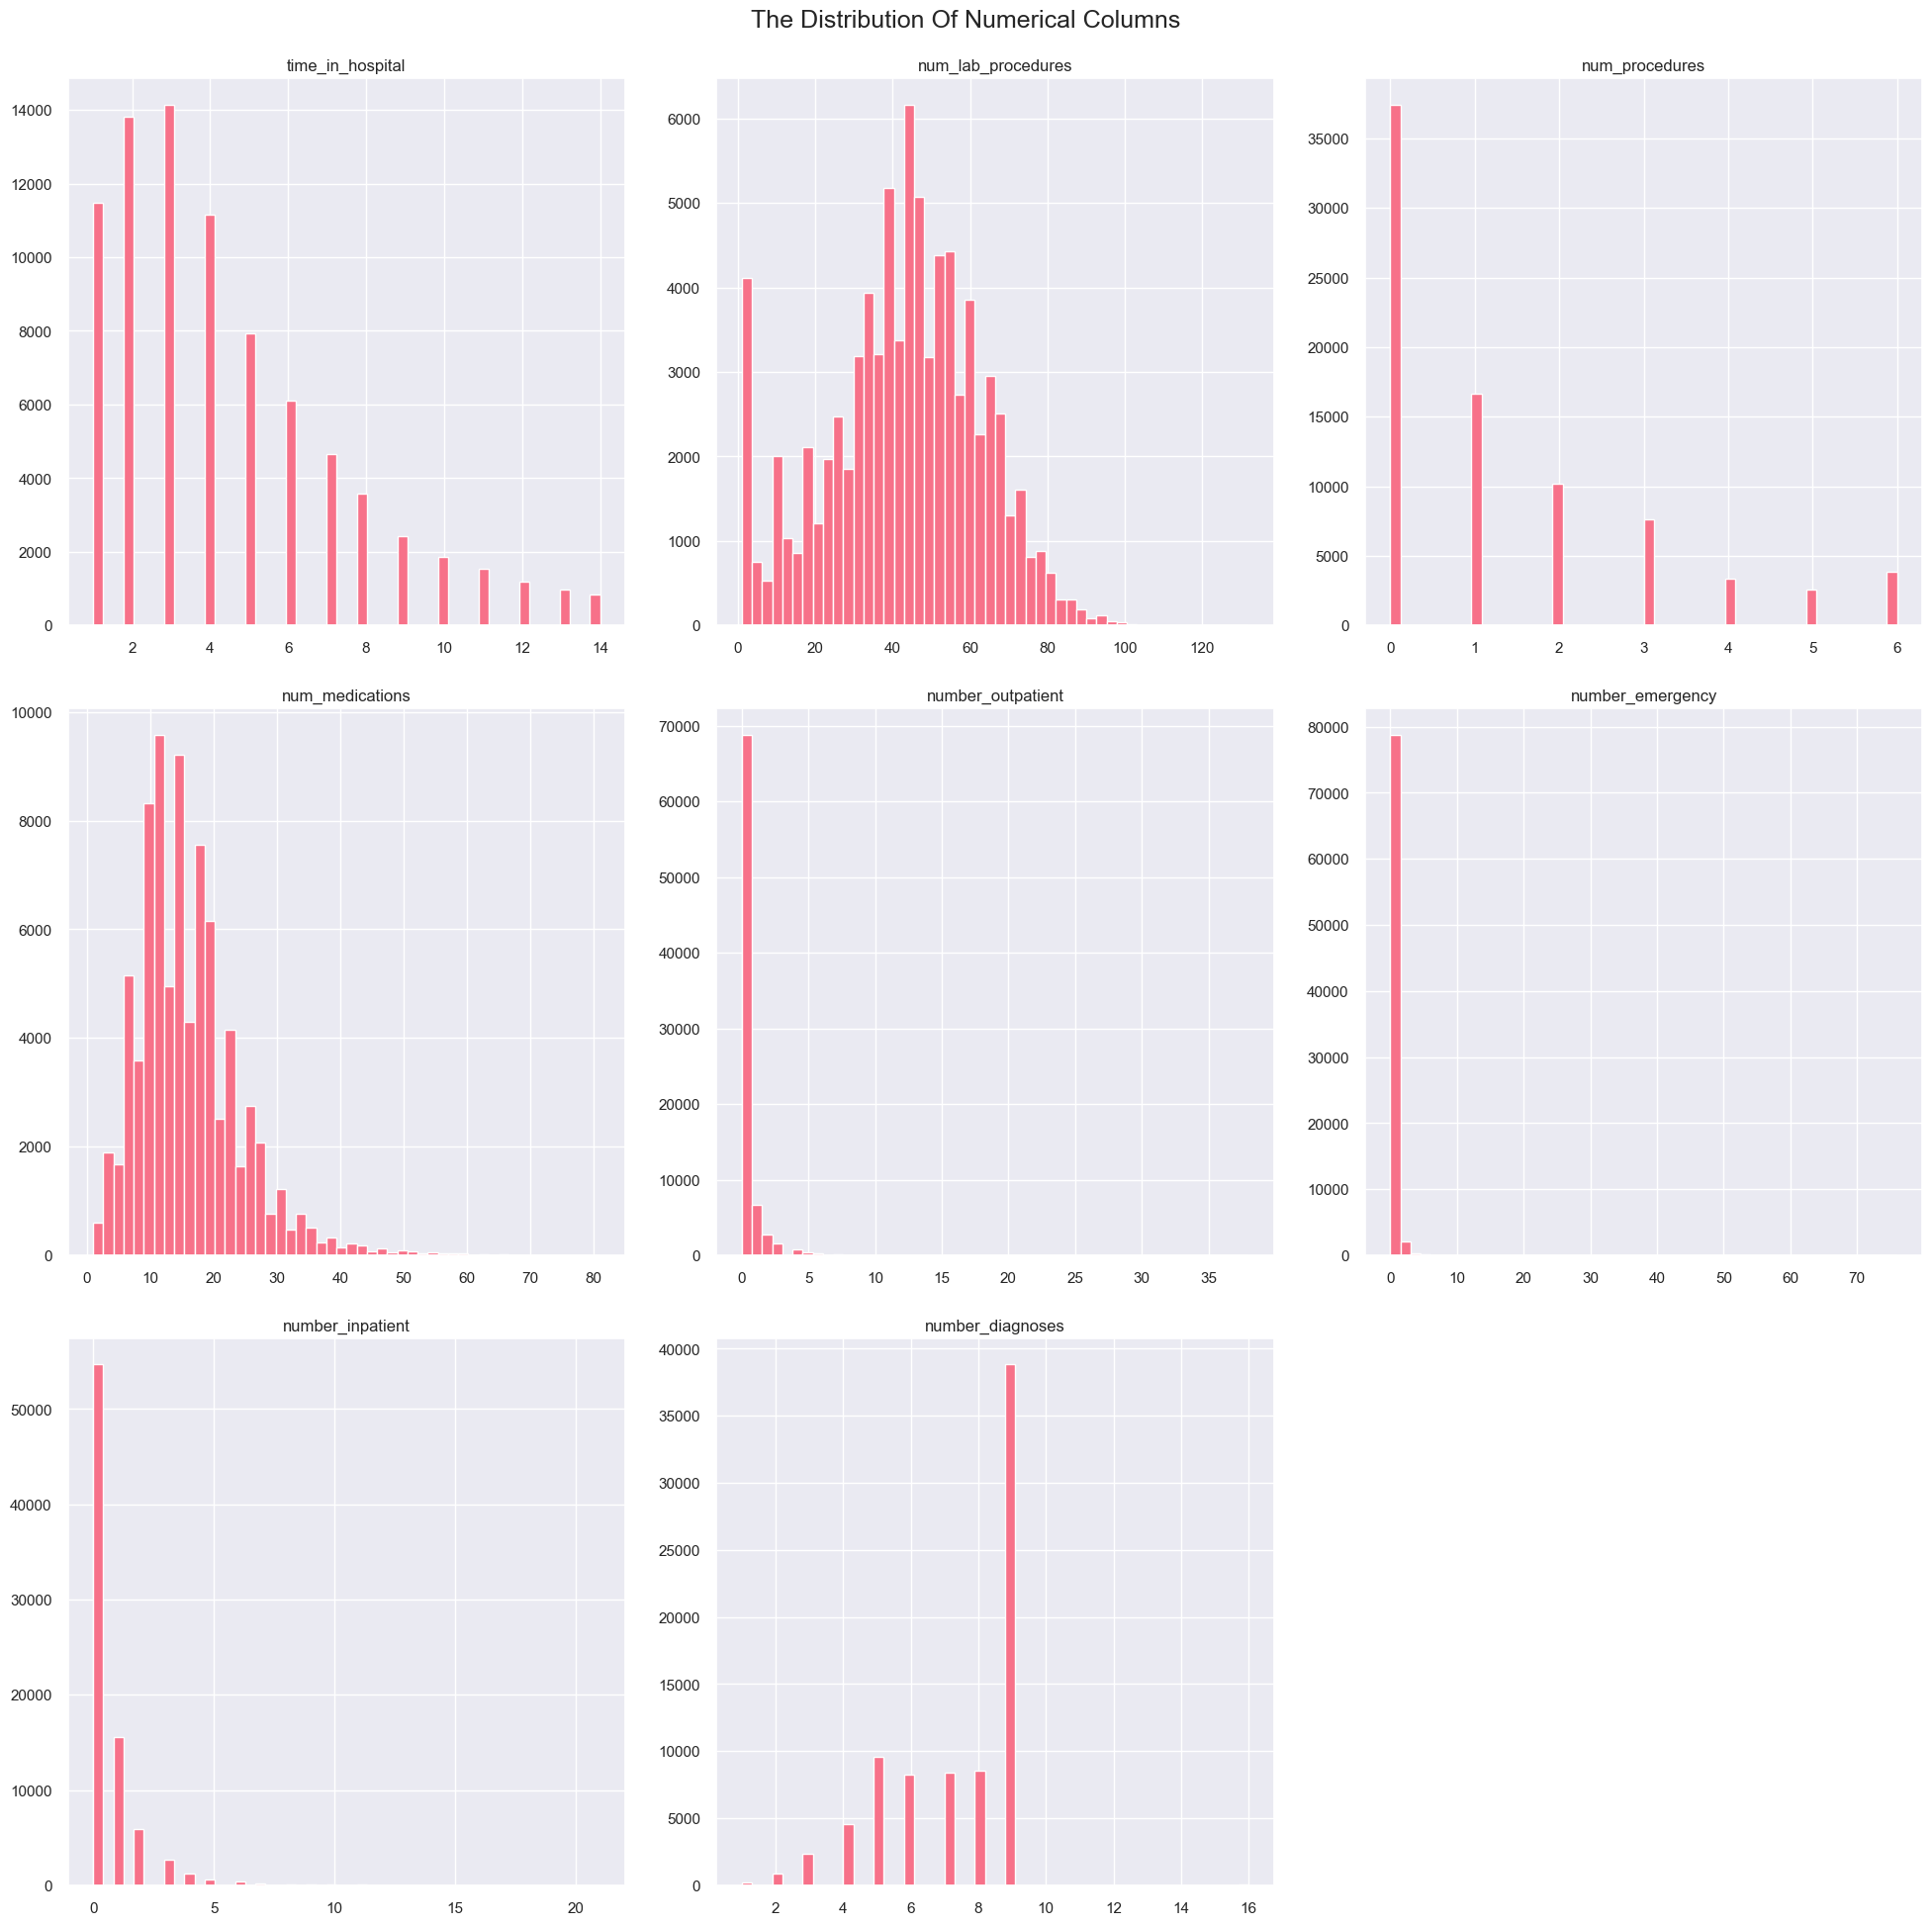

In [42]:
train_data[num_cols].hist(figsize=(20, 20), bins=50)
plt.suptitle('The Distribution Of Numerical Columns', fontsize=18)
plt.tight_layout(pad = 2)

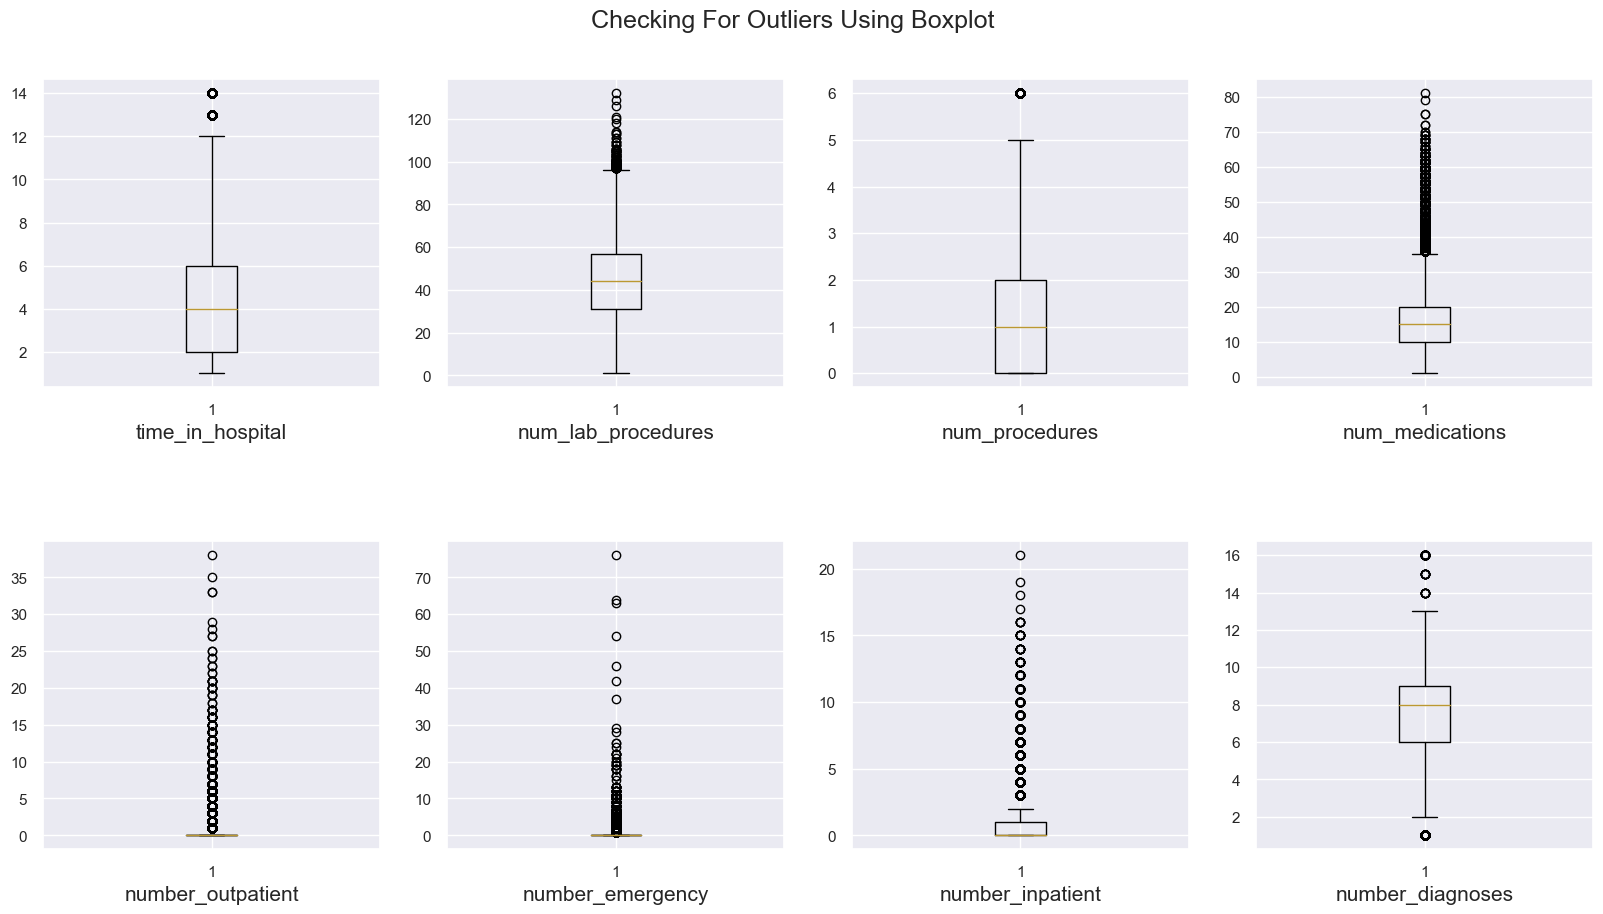

In [43]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Checking For Outliers Using Boxplot", fontsize=18, y=0.95)

for column, ax in zip(num_cols, axs.ravel()):
    ax.boxplot(train_data[column])
    ax.set_xlabel(column, fontsize=15)
plt.show()

Examining the distribution of numerical columns.

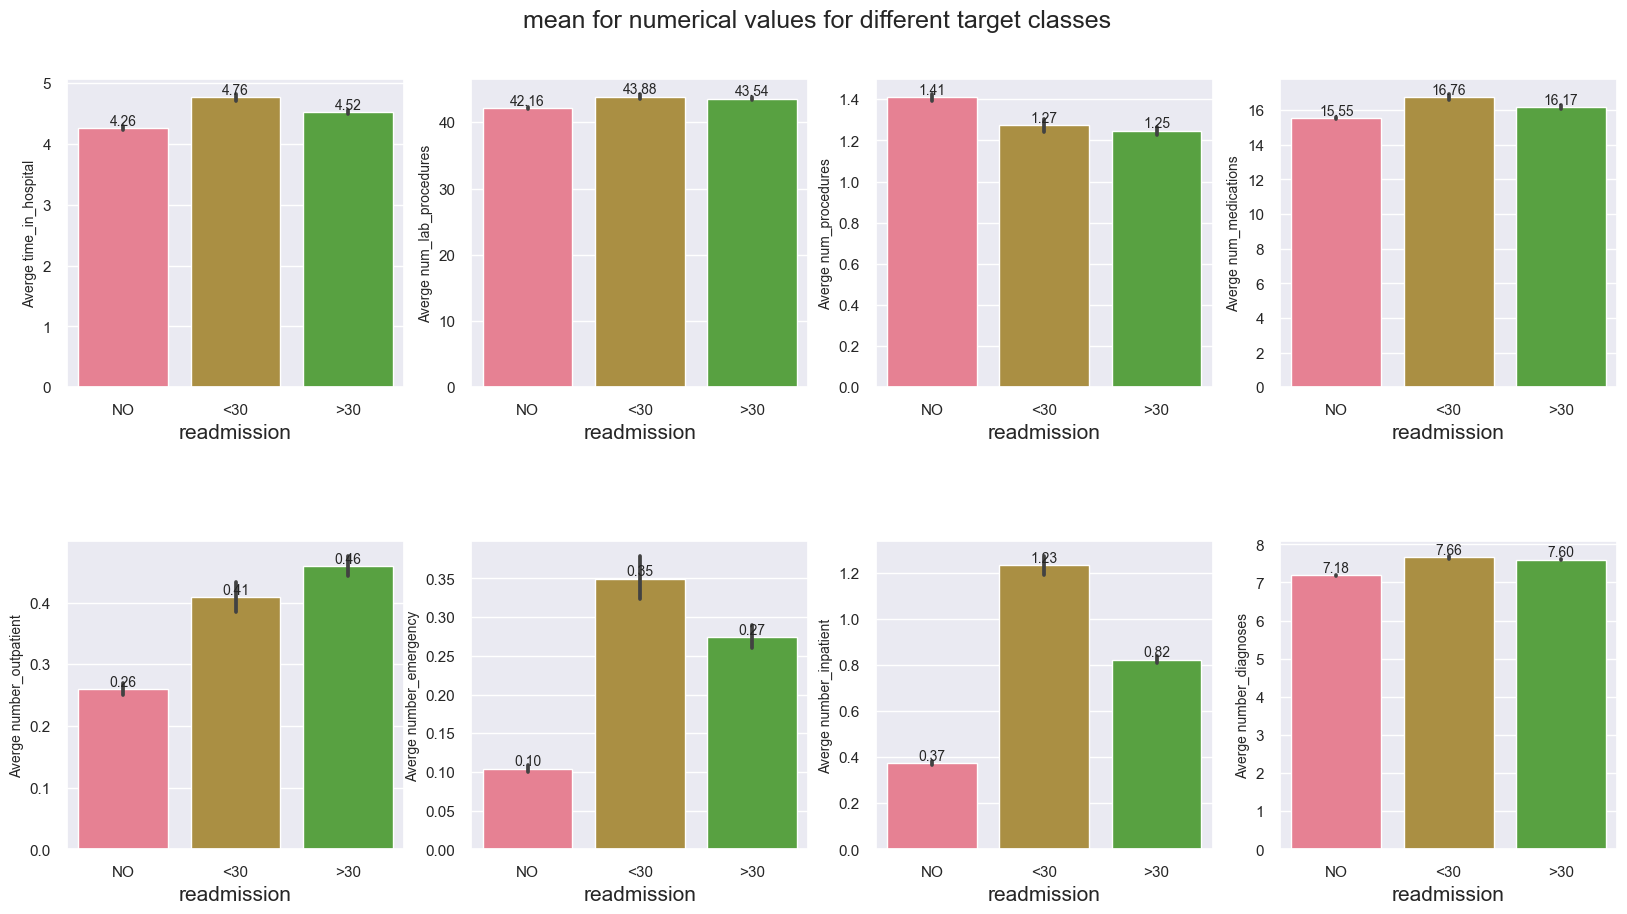

In [44]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("mean for numerical values for different target classes",
             fontsize=18,
             y=0.95)

for column, ax in zip(num_cols, axs.ravel()):
    sns.barplot(x=train_data['readmitted'], y=train_data[column], ax=ax)
    ax.set_xlabel("readmission", fontsize=15)
    ax.set_ylabel(f"Averge {column}", fontsize=10)
    for container in ax.containers:
        ax.bar_label(container, fontsize=10, fmt='%.2f')
plt.show()

The majority of columns exhibit significant skewness. Various transformations and scaling techniques were attempted, yielding nearly identical results.

Examining the mean values for each numerical column across different target classes.

In [45]:
print(train_data.groupby(['patient_nbr'])['patient_nbr'].count().sort_values(ascending=False))

patient_nbr
88785761     30
43140776     23
23198891     22
1660163      20
88227410     18
             ..
31835696      1
31835732      1
31837658      1
31840547      1
189502489     1
Name: patient_nbr, Length: 60563, dtype: int64


It's evident that certain columns, such as number_outpatient, number_emergency, and number_inpatient, exhibit significantly disparate means across different classes. This suggests a strong correlation between these columns and the target classes, indicating their high importance.

In [46]:
train_data[diag_cols[0]].value_counts()


428    5546
414    5430
786    3277
410    2915
486    2778
       ... 
637       1
649       1
133       1
911       1
314       1
Name: diag_1, Length: 690, dtype: int64

# Feature Engineering

The patient number is unique for each patient, and multiple encounters are possible for each patient. Utilizing this information, we will derive two crucial features:

1. Total number of visits
2. Visit number

We'll delve into these features further in the preprocessing section.

In [47]:
X_num = [
    'time_in_hospital', 'num_lab_procedures', 'num_procedures',
    'num_medications', 'number_outpatient', 'number_emergency',
    'number_inpatient', 'number_diagnoses'
]

X_cat = [
    'race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id',
    'admission_source_id', 'max_glu_serum', 'A1Cresult', 'metformin',
    'repaglinide', 'nateglinide', 'glimepiride', 'glipizide', 'glyburide',
    'pioglitazone', 'rosiglitazone', 'insulin', 'change', 'diabetesMed',
    'payer_code'
]

X_diag = ['diag_1', 'diag_2', 'diag_3']

X_id = ['encounter_id', "patient_nbr"]

Following filtration, here are the lists of categorical, numerical, ID, and Diagnoses columns. They will be preprocessed separately in the pipeline.

In [48]:
class IDColumnsTransformer:
    def fit(self, X, y=None):
        self.columns = ['encounter_id', 'patient_nbr']
        self.history = X[self.columns].copy(
            deep=True).set_index('encounter_id').sort_index()
        return self

    def transform(self, X, y=None):
        X_copy = X.copy(deep=True)
        new_data = X_copy[self.columns].set_index('encounter_id').sort_index()
        self.history = pd.concat([self.history, new_data])
        self.history = (self.history.reset_index().drop_duplicates(
            subset='encounter_id',
            keep='last').set_index('encounter_id').sort_index())

        ###visit number
        visits = self.history[['patient_nbr']]

        df_visits = visits.groupby(
            'patient_nbr',
            group_keys=False).apply(lambda x: x.rank(method='first'))
        ans_visits = df_visits.loc[new_data.index, :]['patient_nbr']
        X_copy = pd.merge(X_copy,
                          ans_visits,
                          left_on='encounter_id',
                          right_on=ans_visits.index).rename(
                              {
                                  'patient_nbr_x': 'patient_nbr',
                                  'patient_nbr_y': 'visit_no'
                              },
                              axis=1)

        #how many visits
        patient_visit_count = X_copy['patient_nbr'].map(
            visits['patient_nbr'].value_counts())

        X_copy['visit_times'] = patient_visit_count

        return X_copy

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)

We'll develop an IDColumnsTransformer to process Patient number and Encounter ID, extracting the following:

1. Total Number of Visits:
- Utilizing the unique Patient number, we'll calculate the total number of visits for each patient.

2. Visit Number:
- Each patient may have multiple encounters, distinguishable by the Encounter ID. 
- Lower Encounter IDs correspond to earlier visits.

When applied to test data, the class transforms Patient number and Encounter ID into the new features. It also verifies whether the patient has a history of encounters, updating the total number of visits and the visit number based on the Encounter ID.

This approach enhances the model's performance with additional data and enables better predictions with new data by incorporating more information about patients' hospital visits.



In [49]:
class DiagColumnsTransformer():
    def map_diag(self, s):
        if not isinstance(s, str):
            #handle nans and other types
            return s

        if re.findall(r'^39\d|4[0-5]\d|785$', s):
            '''390–459, 785'''
            return 'Circulatory'

        if re.findall(r'^4[6-9]\d|5[0-1]\d|786$', s):
            '''460–519, 786'''
            return 'Respiratory'

        if re.findall(r'^5[2-7]\d|787$', s):
            '''520–579, 787'''
            return 'Digestive'

        if re.findall(r'^250.*', s):
            '''250.xx'''
            return 'Diabetes'

        if re.findall(r'^[8-9]\d\d$', s): 
            '''800–999'''
            return 'Injury'

        if re.findall(r'^7[1-3]\d$', s):
            '''710–739'''
            return 'Musculoskeletal'

        if re.findall(r'^5[8-9]\d|6[0-2]\d|788$', s):
            '''580–629, 788'''
            return 'Genitourinary'

        if re.findall(r'^[EV]', s, re.I):
            '''contains V or E with codes'''
            return 'other'
        else:
            # we need at least one condition to return just incase
            return 'Neoplasms' 

        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_copy = X.copy(deep=True)
        for col in ['diag_1', 'diag_2', 'diag_3']:
            X_copy[col] = X[col].map(self.map_diag)
        return X_copy
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y) 

Utilizing the diagnosis form description provided, we will associate each diagnosis number with its corresponding category.

In [50]:
cat_pipeline = Pipeline([("mode imputer"  , SimpleImputer(strategy="most_frequent")),
                         ("target encoder", TargetEncoder())])

num_pipeline = Pipeline([('median imputer', SimpleImputer(strategy="median")),
                         ("MinMax scaler" , MinMaxScaler())])

diag_pipeline = Pipeline([('Diagnosis transformer', DiagColumnsTransformer()),
                          ("mode imputer"         , SimpleImputer(strategy="most_frequent")),
                          ("target encoder"       , TargetEncoder())])

id_pipeline = Pipeline([("encoder"       , IDColumnsTransformer()),
                        ("Min max scaler", MinMaxScaler())])

full_pipeline = ColumnTransformer(transformers=[("num", num_pipeline, X_num),
                                                ("cat", cat_pipeline, X_cat),
                                                ("id", id_pipeline, X_id),
                                                ("diag", diag_pipeline, X_diag)],
                                                remainder='drop') # remove other columns

For each data type, we'll apply the following transformations:

1. Categorical columns: Mode Imputer -> KeepTopValuesTransformer -> Target Encoder
2. Numerical columns: Median Imputer -> MinMax Scaler
3. Diagnosis columns: Diagnosis Transformer -> Mode Imputer -> Target Encoder
4. ID columns: ID Columns Transformer -> MinMax Scaler

While these choices may seem straightforward, they were arrived at through experimentation. Surprisingly, variations in scaling, transformation, binning, encoding, and imputing methods didn't significantly impact performance.

In [51]:
le = LabelEncoder()
y_train_prepared = le.fit_transform(y_train)
print("Shape of y_train:", y_train_prepared.shape)


Shape of y_train: (81689,)


Performing label encoding on both training and testing data to address models that cannot handle categorical targets.

In [52]:
y_test_prepared = le.transform(y_test)
print("Shape of y_test:", y_test_prepared.shape)

Shape of y_test: (9077,)


In [53]:
X_train_prepared = full_pipeline.fit_transform(X_train,y_train_prepared)
print("Shape of X_train:", X_train_prepared.shape)

Shape of X_train: (81689, 35)


Using .fit_transform() on the training data and .transform() on the testing data.

In [54]:
X_test_prepared = full_pipeline.transform(X_test)
print("Shape of X_test:", X_test_prepared.shape)

Shape of X_test: (9077, 35)


# Use of a baseline predictor and noting the related performance metrics

Here we have selected several baseline models (no hyperparameter tuning) and checked the performance

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
import xgboost as xgb

models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(random_state=42, verbose=0),
    "XGBoost": xgb.XGBClassifier(random_state=42, verbosity=0) 
}


Training Logistic Regression...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


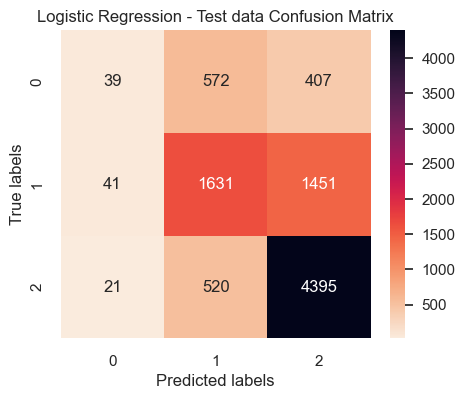

              precision    recall  f1-score   support

           0       0.39      0.04      0.07      1018
           1       0.60      0.52      0.56      3123
           2       0.70      0.89      0.79      4936

    accuracy                           0.67      9077
   macro avg       0.56      0.48      0.47      9077
weighted avg       0.63      0.67      0.63      9077

Training Random Forest...


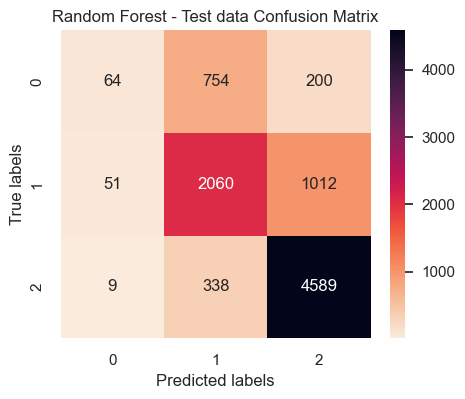

              precision    recall  f1-score   support

           0       0.52      0.06      0.11      1018
           1       0.65      0.66      0.66      3123
           2       0.79      0.93      0.85      4936

    accuracy                           0.74      9077
   macro avg       0.65      0.55      0.54      9077
weighted avg       0.71      0.74      0.70      9077

Training Decision Tree...


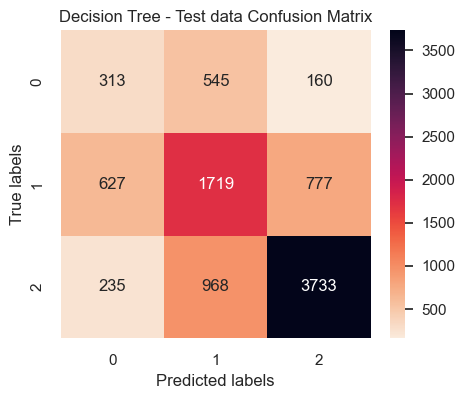

              precision    recall  f1-score   support

           0       0.27      0.31      0.29      1018
           1       0.53      0.55      0.54      3123
           2       0.80      0.76      0.78      4936

    accuracy                           0.64      9077
   macro avg       0.53      0.54      0.53      9077
weighted avg       0.65      0.64      0.64      9077

Training CatBoost...


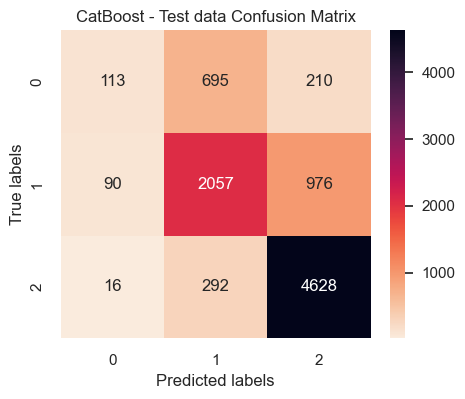

              precision    recall  f1-score   support

           0       0.52      0.11      0.18      1018
           1       0.68      0.66      0.67      3123
           2       0.80      0.94      0.86      4936

    accuracy                           0.75      9077
   macro avg       0.66      0.57      0.57      9077
weighted avg       0.72      0.75      0.72      9077

Training XGBoost...


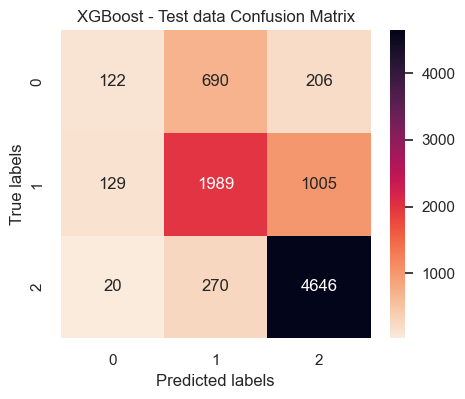

              precision    recall  f1-score   support

           0       0.45      0.12      0.19      1018
           1       0.67      0.64      0.66      3123
           2       0.79      0.94      0.86      4936

    accuracy                           0.74      9077
   macro avg       0.64      0.57      0.57      9077
weighted avg       0.71      0.74      0.71      9077



In [56]:
# Assuming X_train_prepared, X_test_prepared, y_train_prepared, y_test_prepared are already defined

# Store evaluation metrics
evaluation_results = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_prepared, y_train_prepared)
    
    # Predict on training and test sets
    train_pred = model.predict(X_train_prepared)
    test_pred = model.predict(X_test_prepared)
    
    # Evaluation
    train_f1 = f1_score(y_train_prepared, train_pred, average="micro")
    test_f1 = f1_score(y_test_prepared, test_pred, average="micro")
    
    evaluation_results[name] = {
        "train_f1": train_f1,
        "test_f1": test_f1
    }
    
    # Confusion Matrix for test set
    cm = confusion_matrix(y_test_prepared, test_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='g', cmap="rocket_r")
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'{name} - Test data Confusion Matrix')
    plt.show()
    
    # Classification report for test set
    print(classification_report(y_test_prepared, test_pred))
    
    # Store or display other evaluation metrics as needed


# Feature importance from models. 

Text(0.5, 1.0, 'Feature Importance - Random Forest')

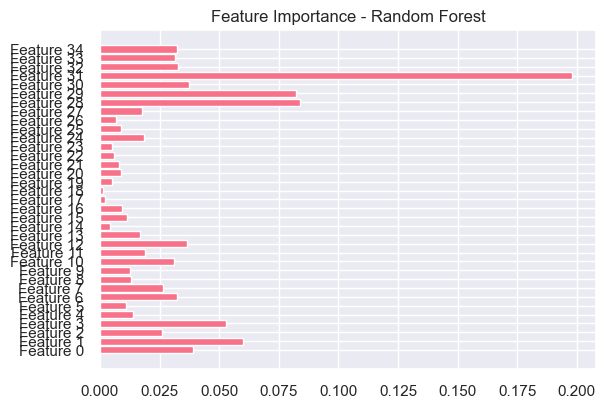

In [57]:
plt.barh(range(len(models['Random Forest'].feature_importances_)), models['Random Forest'].feature_importances_, tick_label=[f'Feature {i}' for i in range(len(models['Random Forest'].feature_importances_))]); plt.title('Feature Importance - Random Forest')


Text(0.5, 1.0, 'Feature Importance - XGBoost')

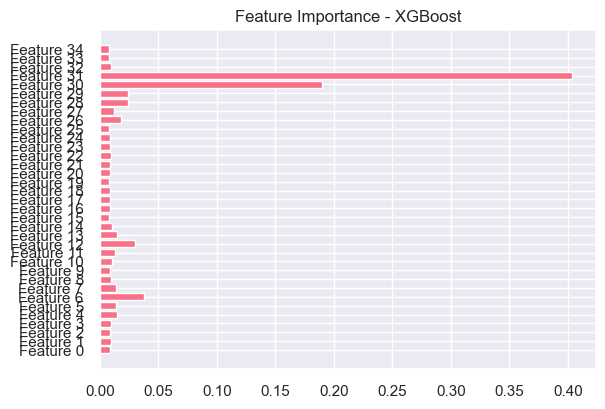

In [58]:
plt.barh(range(len(models['XGBoost'].feature_importances_)), models['XGBoost'].feature_importances_, tick_label=[f'Feature {i}' for i in range(len(models['XGBoost'].feature_importances_))]); plt.title('Feature Importance - XGBoost')


# Hyper parameter tuning

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
import xgboost as xgb

# Define your models
models = {
    "LogisticRegression": LogisticRegression(random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(random_state=42, verbose=0),
    "XGBoost": xgb.XGBClassifier(random_state=42, verbosity=0) 
}

# Define parameter grids for hyperparameter tuning
param_grids = {
    "LogisticRegression": {"C": [0.01, 0.1, 1, 10, 100]},
    "RandomForest": {"n_estimators": [10, 50, 100], "max_depth": [None, 10, 20, 30]},
    "DecisionTree": {"max_depth": [None, 10, 20, 30]},
    "CatBoost": {"learning_rate": [0.01, 0.05, 0.1], "depth": [4, 6, 10]},
    "XGBoost": {"learning_rate": [0.01, 0.05, 0.1], "max_depth": [3, 6, 9]}
}


In [60]:
# best_estimators = {}
# for name in models:
#     print(f"Training and tuning {name}")
#     model = models[name]
#     param_grid = param_grids[name]
    
#     # Choose between GridSearchCV or RandomizedSearchCV based on your preference
#     clf = GridSearchCV(model, param_grid, scoring="f1_micro", cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42))
    
#     clf.fit(X_train_prepared, y_train_prepared)
#     best_estimators[name] = clf.best_estimator_
#     print(f"Best parameters for {name}: {clf.best_params_}")
best_model = None
best_f1_score = 0

for name in models:
    print(f"Training and tuning {name}")
    model = models[name]
    param_grid = param_grids[name]
    
    # Hyper-parameter tuning using GridSearchCV
    clf = GridSearchCV(model, param_grid, scoring="f1_micro", cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42))
    
    clf.fit(X_train_prepared, y_train_prepared)
    best_estimator = clf.best_estimator_
    print(f"Best parameters for {name}: {clf.best_params_}")
    
    # Predict on the test set
    predictions = best_estimator.predict(X_test_prepared)
    
    # Evaluate F1 score on the test set
    f1 = f1_score(y_test_prepared, predictions, average="micro")
    print(f"F1 Score on Test set: {f1}")
    
    if f1 > best_f1_score:
        best_f1_score = f1
        best_model = best_estimator

print("Best Model:")
print(best_model)
print("Best F1 Score on Test set:", best_f1_score)

Training and tuning LogisticRegression


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

Best parameters for LogisticRegression: {'C': 10}
F1 Score on Test set: 0.6755535970034152
Training and tuning RandomForest
Best parameters for RandomForest: {'max_depth': None, 'n_estimators': 100}
F1 Score on Test set: 0.7395615291395836
Training and tuning DecisionTree
Best parameters for DecisionTree: {'max_depth': 10}
F1 Score on Test set: 0.7326209099922882
Training and tuning CatBoost
Best parameters for CatBoost: {'depth': 6, 'learning_rate': 0.1}
F1 Score on Test set: 0.7504682163710477
Training and tuning XGBoost
Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 6}
F1 Score on Test set: 0.7505783849289412
Best Model:
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
      

Accuracy: 0.7506

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.09      0.16      1018
           1       0.68      0.65      0.67      3123
           2       0.79      0.95      0.86      4936

    accuracy                           0.75      9077
   macro avg       0.67      0.56      0.56      9077
weighted avg       0.73      0.75      0.72      9077



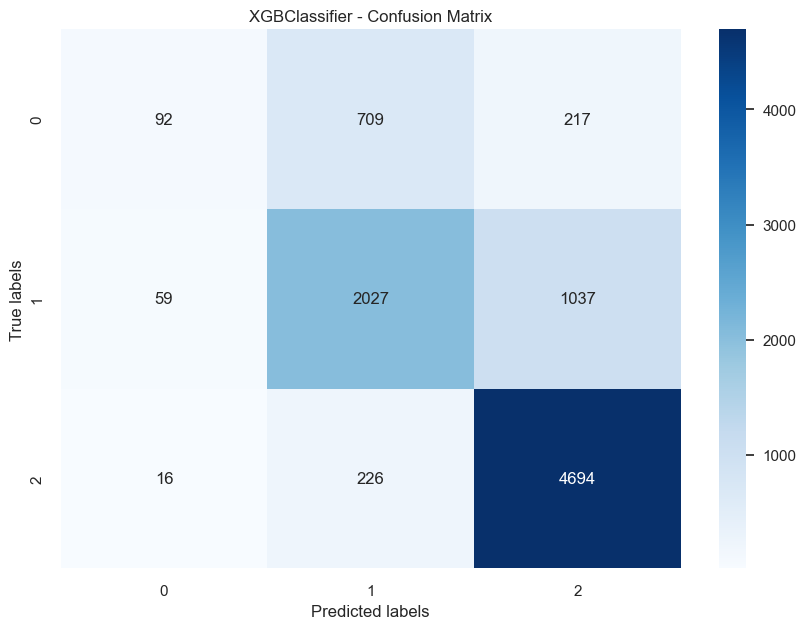

In [63]:
# from sklearn.metrics import classification_report, accuracy_score

# for name, model in best_model.items():
#     print(f"Evaluating {name}")
    
#     # Predict on the test set
#     predictions = model.predict(X_test_prepared)
    
#     # Accuracy
#     accuracy = accuracy_score(y_test_prepared, predictions)
#     print(f"Accuracy: {accuracy:.4f}")
    
#     # Classification report
#     print("\nClassification Report:")
#     print(classification_report(y_test_prepared, predictions))
    
#     # Confusion Matrix
#     cm = confusion_matrix(y_test_prepared, predictions)
#     plt.figure(figsize=(10,7))
#     sns.heatmap(cm, annot=True, fmt="g", cmap="Blues")
#     plt.xlabel('Predicted labels')
#     plt.ylabel('True labels')
#     plt.title(f'{name} - Confusion Matrix')
#     plt.show()
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming best_model is an instance of a trained XGBClassifier
# and X_test_prepared, y_test_prepared are already defined

# Predict on the test set
predictions = best_model.predict(X_test_prepared)

# Accuracy
accuracy = accuracy_score(y_test_prepared, predictions)
print(f"Accuracy: {accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test_prepared, predictions))

# Confusion Matrix
cm = confusion_matrix(y_test_prepared, predictions)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="g", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('XGBClassifier - Confusion Matrix')
plt.show()


In [69]:



final_model = xgb.XGBClassifier(learning_rate=0.1, max_depth=6)
final_model.fit(X_train_prepared, y_train_prepared)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

# Model evaluation

In [70]:
train_pred = final_model.predict(X_train_prepared)
print("train f1 score:",f1_score(train_pred, y_train_prepared,average="micro"))

train f1 score: 0.7523534380393934


# Cross Validation

In [71]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

scores = cross_val_score(final_model,
                         X_train_prepared,
                         y_train_prepared,
                         scoring="f1_micro",
                         cv=skf)

print("cross validation Scores:\n", scores,"\n")
print("cross validation Scores std:", scores.std())
print("cross validation Scores mean:", scores.mean())

cross validation Scores:
 [0.73117885 0.72909781 0.73632024 0.72603746 0.73313747 0.73913576
 0.739503   0.73387195 0.73105643 0.73971596] 

cross validation Scores std: 0.004465902102260112
cross validation Scores mean: 0.7339054929117975


# Performance on test data 

In [72]:
test_pred = final_model.predict(X_test_prepared)
print("test f1 score:",f1_score(test_pred, y_test_prepared,average="micro"))

test f1 score: 0.7505783849289412


[Text(0, 0.5, '<30'), Text(0, 1.5, '>30'), Text(0, 2.5, 'NO')]

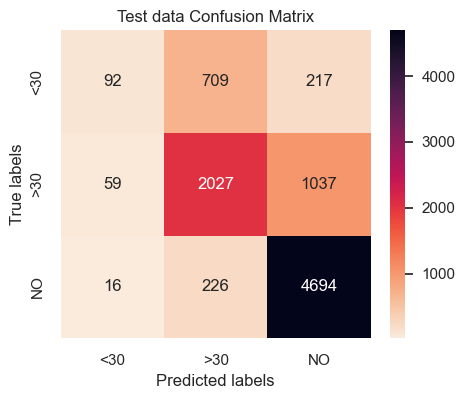

In [73]:
f = plt.figure(figsize = (5,4))
ax = f.add_subplot()
cm = confusion_matrix(y_test_prepared, test_pred)
sns.heatmap(cm, annot=True, fmt='g',cmap="rocket_r", ax=ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Test data Confusion Matrix')
ax.xaxis.set_ticklabels(le.classes_)
ax.yaxis.set_ticklabels(le.classes_)

In [74]:
print(classification_report(y_test_prepared, test_pred, target_names=le.classes_))


              precision    recall  f1-score   support

         <30       0.55      0.09      0.16      1018
         >30       0.68      0.65      0.67      3123
          NO       0.79      0.95      0.86      4936

    accuracy                           0.75      9077
   macro avg       0.67      0.56      0.56      9077
weighted avg       0.73      0.75      0.72      9077



# Bonus: Measuring the peformance of the model as if it were a binary classification problem.



In [75]:
mapping = dict(zip(le.classes_, range(len(le.classes_))))
print(mapping)

{'<30': 0, '>30': 1, 'NO': 2}


In [76]:
test_pred[(test_pred == 0)] = 1
y_test_prepared[(y_test_prepared == 0)] = 1
print("test Binary f1 score:",f1_score(test_pred, y_test_prepared, average="micro"))

test Binary f1 score: 0.8351878373912085


# Creating C2T1_Test_Lableled.csv 

In [77]:
test_df = pd.read_csv(os.path.join(dataset_path, 'C2T1_Test.csv'), na_values='?')


In [78]:
test_df_prepared = full_pipeline.transform(test_df)


In [79]:
test_df_predictions = final_model.predict(test_df_prepared)
y_test_predicted = le.inverse_transform(test_df_predictions)

In [80]:
test_df['readmitted'] = y_test_predicted
test_df[['encounter_id','patient_nbr', 'readmitted']].to_csv('C2T1_Test_Lableled.csv', index=False)